In [2]:
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataloader import default_collate

import time
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224), antialias = True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

BATCH_SIZE = 64
TEST_SIZE = 0.2

ROOT = ''
NET_NAME_1 = 'net_1.pt'
DATASET_FOLDER = 'dataset_by_classes'
DATASET_CLASES = 'train.csv'
DATA_ROOT = DATASET_FOLDER

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
dataset = datasets.ImageFolder(DATA_ROOT, 
                               transform=transform)
classes = dataset.classes
classes

['1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '15',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '16',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '17',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '18',
 '180',
 '181',
 '182',
 '183',
 '184',
 '185',
 '186',
 '187',
 '188',
 '189',
 '19',
 '190',
 '191',
 '192',
 '193',
 '194',
 '195',
 '196',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '3

In [5]:
train_set, test_set = torch.utils.data.random_split(dataset,
                                                    [1-TEST_SIZE, TEST_SIZE], 
                                                    generator=torch.Generator().manual_seed(1))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  
                                        collate_fn=lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x)))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, 
                                        collate_fn=lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x)))
test_len = len(test_set)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])


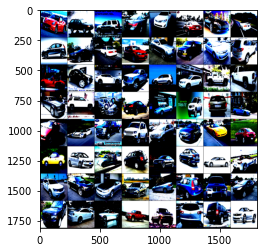

In [6]:
def imshow(img):
    img_np = img.cpu().numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break


In [7]:
def save_model(model, path, name):
  model_scripted = torch.jit.script(model)
  model_scripted.save(path + name)

In [8]:
def my_accuracy(net, test_loader):
  correct = 0
  total = 0
  # поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
  with torch.no_grad():
      for data in test_loader:
          images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
          # рассчитываем выходные данные, пропуская изображения через сеть
          outputs = net(images)
          # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the test images: {100 * correct // total} %')
  return 100 * correct // total

In [9]:
def fit(model, train_dataloader, optim, criterion):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        # images, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        optim.zero_grad()
        output = model(images)

        loss = criterion(output, labels)
        train_running_loss += loss.item()
        loss.backward()
        optim.step()

        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == labels).sum().item()
        if i*BATCH_SIZE % 120 == 0 :
          print(i*BATCH_SIZE, '/', len(train_dataloader.dataset), ': loss = ', loss.item())
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
    
    return train_loss, train_accuracy

In [10]:
def IndexToClass(i):
  return i+1
def ClassToIndex(c):
  return c-1

#VGG16

In [11]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(DEVICE)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
# меняем число выходов
vgg16.classifier[6].out_features = len(dataset.classes)

# замораживаем веса сверточных слоев
for param in vgg16.features.parameters():
    param.requires_grad = False

In [13]:
# optimizer
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.01)
# loss function
criterion = nn.CrossEntropyLoss()
max_epochs = 5

In [14]:
import gc
torch.cuda.empty_cache()
gc.collect()

3333

In [15]:
model = vgg16

In [16]:
for epoch in range(4): 
    running_loss = 0.0
    for j, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if j % 20 == 0: 
            print(f'[{epoch + 1}, {j + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
print('Finished Training')

# path = './cats_net_resnet50.pth'
# print(path)
# torch.save(model.state_dict(), path)

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images)

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {test_len} test images: {100 * correct // total} %')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

[1,     2] loss: 34.957
[1,    22] loss: 225.795
[1,    42] loss: 15.108
[1,    62] loss: 13.882
[1,    82] loss: 13.194
[2,     2] loss: 1.600
[2,    22] loss: 12.553
[2,    42] loss: 12.603
[2,    62] loss: 12.238
[2,    82] loss: 12.104
[3,     2] loss: 1.162
[3,    22] loss: 12.301
[3,    42] loss: 11.942
[3,    62] loss: 11.635
[3,    82] loss: 11.517
[4,     2] loss: 1.115
[4,    22] loss: 11.724
[4,    42] loss: 11.223
[4,    62] loss: 11.109
[4,    82] loss: 11.663
Finished Training
Accuracy of the network on the 1397 test images: 1 %
Accuracy for class: 1     is 0.0 %
Accuracy for class: 10    is 0.0 %
Accuracy for class: 100   is 0.0 %
Accuracy for class: 101   is 0.0 %
Accuracy for class: 102   is 0.0 %
Accuracy for class: 103   is 0.0 %
Accuracy for class: 104   is 0.0 %
Accuracy for class: 105   is 0.0 %
Accuracy for class: 106   is 0.0 %
Accuracy for class: 107   is 0.0 %
Accuracy for class: 108   is 0.0 %
Accuracy for class: 109   is 0.0 %
Accuracy for class: 11    is 0.

In [17]:
# train_loss , train_accuracy = [], []
# start = time.time()

# for epoch in range(max_epochs):
#     print("epoch - ", epoch)
#     train_epoch_loss, train_epoch_accuracy = fit(vgg16, train_loader, optimizer, criterion)
#     train_loss.append(train_epoch_loss)
#     train_accuracy.append(train_epoch_accuracy)

# end = time.time()
# print((end-start)/60, 'minutes')

In [18]:
save_model(vgg16, './', NET_NAME_1)

In [ ]:
# plt.figure(figsize=(5, 3))
# plt.plot(train_accuracy, color='green', label='train accuracy')
# plt.legend()
# plt.savefig('accuracy.png')
# plt.show()

In [ ]:
# accuracy_1 = my_accuracy(vgg16, test_loader)
# accuracy_1